In [3]:
from __future__ import division
import time

import click
import numpy as np

import nn
import data
import tta
import util
from lasagne.layers import get_output
import theano
from theano import tensor as T

In [39]:
# cnf = 'configs/c_512_5x5_32.py'
# weights_from = 'weights_VIP/c_512_5x5_32/best/0217_2017-02-28-17-51-48_0.302194565535.pkl'
cnf = 'configs_CAM/c_128_5x5_32.py'
weights_from = 'weights_CAM//c_128_5x5_32/best/0196_2017-03-16-00-55-26_0.595941841602.pkl'
# cnf = 'configs_CAM/c_256_5x5_32.py'
# weights_from = 'weights_CAM//c_256_5x5_32/best/0189_2017-03-16-10-42-45_0.538861095905.pkl'
n_iter = 1
skip = 0
test = False
train = True

test_dir = None

In [40]:
reload(nn)
config = util.load_module(cnf).config

config.cnf['batch_size_train'] = 128
config.cnf['batch_size_test'] = 128
runs = {}
if train:
    runs['train'] = config.get('train_dir')
if test or test_dir:
    runs['test'] = test_dir or config.get('test_dir')

net = nn.create_net(config)

if weights_from is None:
    net.load_params_from(config.weights_file)
    print("loaded weights from {}".format(config.weights_file))
else:
    weights_from = str(weights_from)
    net.load_params_from(weights_from)
    print("loaded weights from {}".format(weights_from))

Loaded parameters to layer 'conv2dcc2' (shape 3x5x5x32).
Loaded parameters to layer 'conv2dcc2' (shape 32x112x112).
Loaded parameters to layer 'conv2dcc3' (shape 32x3x3x32).
Loaded parameters to layer 'conv2dcc3' (shape 32x112x112).
Loaded parameters to layer 'conv2dcc5' (shape 32x5x5x64).
Loaded parameters to layer 'conv2dcc5' (shape 64x56x56).
Loaded parameters to layer 'conv2dcc6' (shape 64x3x3x64).
Loaded parameters to layer 'conv2dcc6' (shape 64x56x56).
Loaded parameters to layer 'conv2dcc7' (shape 64x3x3x64).
Loaded parameters to layer 'conv2dcc7' (shape 64x56x56).
Loaded parameters to layer 'conv2dcc9' (shape 64x3x3x128).
Loaded parameters to layer 'conv2dcc9' (shape 128x54x54).
Loaded parameters to layer 'conv2dcc10' (shape 128x3x3x128).
Loaded parameters to layer 'conv2dcc10' (shape 128x54x54).
Loaded parameters to layer 'conv2dcc11' (shape 128x3x3x128).
Loaded parameters to layer 'conv2dcc11' (shape 128x54x54).
Loaded parameters to layer 'dense14' (shape 128x1).
Loaded parame

In [41]:
tfs, color_vecs = tta.build_quasirandom_transforms(
       n_iter, skip=skip, color_sigma=0.0,
        **data.no_augmentation_params)

ret_val_x = []
ret_val_y = []
for run, directory in sorted(runs.items(), reverse=True):

    print("extracting features for files in {}".format(directory))
    tic = time.time()
    files = data.get_image_files(directory)

    Xs, Xs2 = None, None

    for i, (tf, color_vec) in enumerate(zip(tfs, color_vecs), start=1):

        print("{} transform iter {}".format(run, i))

        X = net.last_conv(files[:1000], transform=tf, color_vec=color_vec)
        Y = net.predict(files[:1000], transform=tf, color_vec=color_vec)
        ret_val_x.append(X)
        ret_val_y.append(Y)

extracting features for files in data/train_tiny
train transform iter 1
(128, 128, 54, 54)
(128, 128, 54, 54)
(128, 128, 54, 54)
(128, 128, 54, 54)
(128, 128, 54, 54)
(128, 128, 54, 54)
(128, 128, 54, 54)
(104, 128, 54, 54)
(128, 1)
(128, 1)
(128, 1)
(128, 1)
(128, 1)
(128, 1)
(128, 1)
(104, 1)


In [42]:
ret_val_x = np.stack(ret_val_x, axis=0).squeeze()
ret_val_y = np.stack(ret_val_y, axis=0).squeeze()
softmax = net.get_all_params_values()
softmax = softmax[softmax.keys()[-1]][0]
CAM = np.dot(ret_val_x.transpose(0,2,3,1), softmax).squeeze()
names = data.get_names(files)
labels = data.get_labels(names).astype(np.float32)
pred = ret_val_y

In [236]:
k=26
print 'pred:'+str(pred[k])+' true:'+str(labels[k])
print 'pred:'+str(pred256[k])+' true:'+str(labels[k])

pred:0.385514 true:1.0
pred:0.0 true:1.0


pred:0.385514 true:1.0
pred:0.0 true:1.0


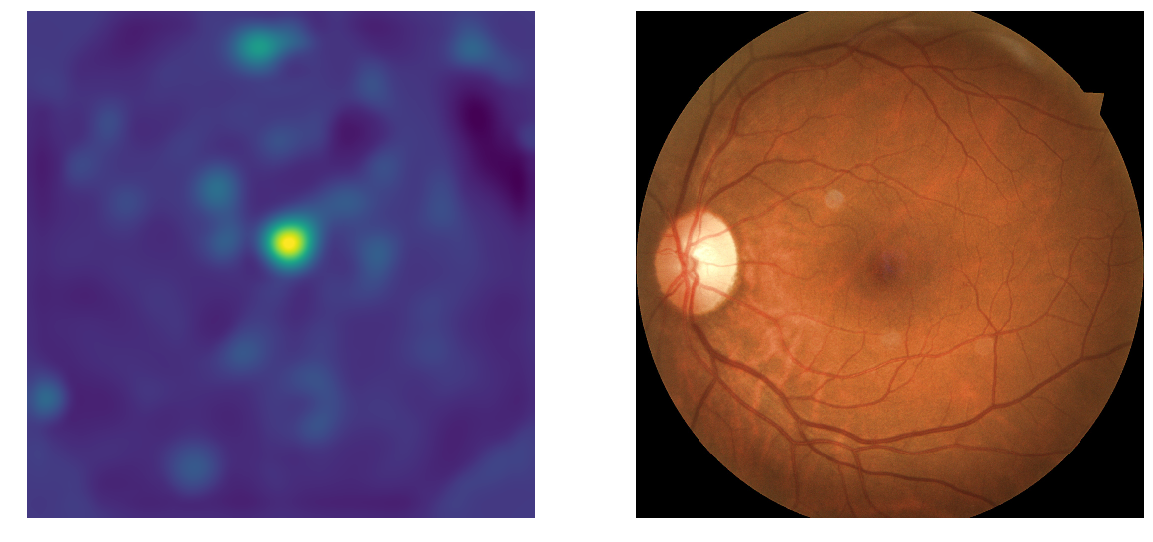

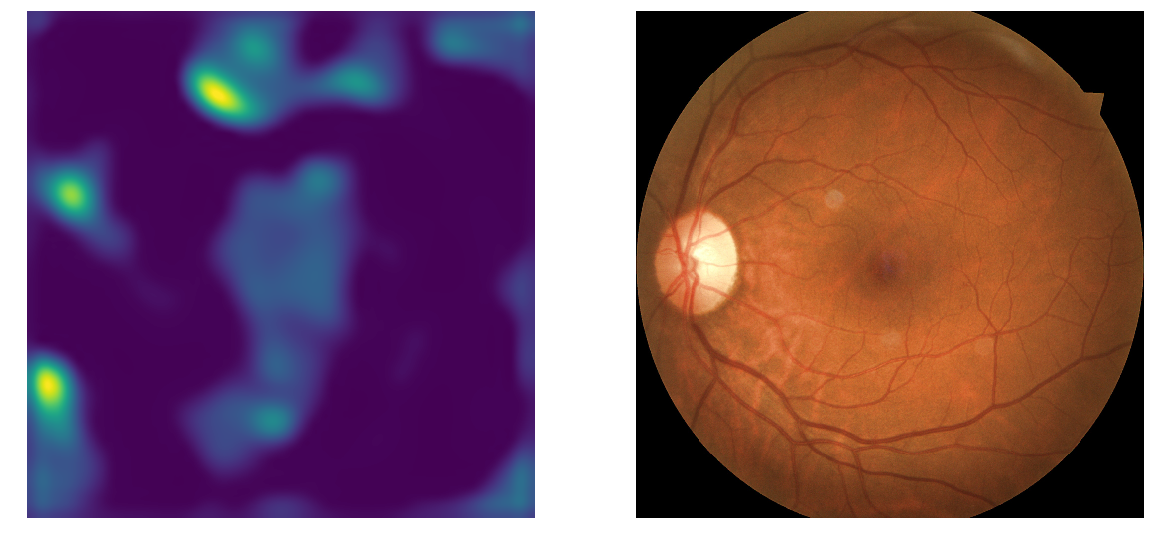

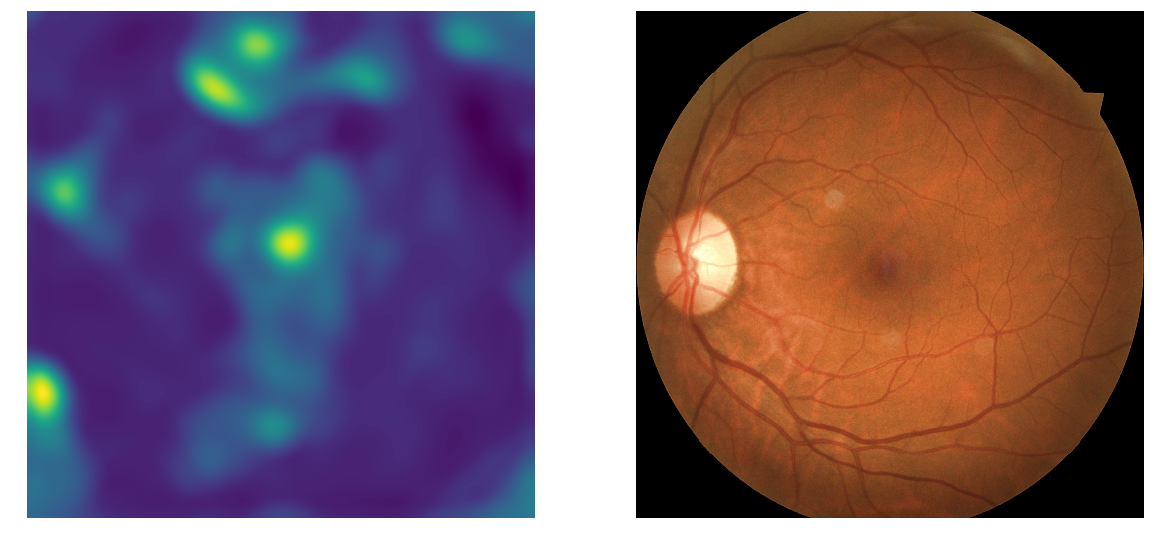

In [237]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
k =26#4:584 3:
im = Image.open('data/train_medium/'+names[k]+'.tiff')
# plt.figure();plt.subplot(1,2,1);plt.imshow(CAM[k]);plt.title(names[k]);plt.subplot(1,2,2);plt.imshow(im);plt.title('pred:'+str(pred[k]))
# plt.figure();plt.imshow(im);plt.title('true: '+str(labels[k]))
plt.figure(figsize=(20,16));plt.subplot(1,2,1);plt.imshow(CAM[k], interpolation='lanczos');plt.axis('off')#plt.title(names[k]);
plt.subplot(1,2,2);plt.imshow(im);plt.axis('off')#plt.title('pred:'+str(pred[k])+' true:'+str(labels[k]))

# plt.figure();plt.subplot(1,2,1);plt.imshow(CAM[k]);plt.title(names[k]);plt.subplot(1,2,2);plt.imshow(im);plt.title('pred:'+str(pred[k]))
# plt.figure();plt.imshow(im);plt.title('true: '+str(labels[k]))
plt.figure(figsize=(20,16));plt.subplot(1,2,1);plt.imshow(CAM256[k], interpolation='lanczos');plt.axis('off')#plt.title(names[k]);
plt.subplot(1,2,2);plt.imshow(im);plt.axis('off')#plt.title('pred:'+str(pred256[k])+' true:'+str(labels[k]))

#CAM_syn = pred256[k]/(pred256[k]+pred128[k])*(CAM256[k][1:55,1:55] - CAM256[k][1:55,1:55].min())/(CAM256[k][1:55,1:55].max() - CAM256[k][1:55,1:55].min())  + pred128[k]/(pred256[k]+pred128[k])*(CAM[k] - CAM[k].min())/(CAM[k].max() - CAM[k].min())
CAM_syn = (CAM256[k][1:55,1:55] - CAM256[k][1:55,1:55].min())/(CAM256[k][1:55,1:55].max() - CAM256[k][1:55,1:55].min())  + (CAM[k] - CAM[k].min())/(CAM[k].max() - CAM[k].min())
plt.figure(figsize=(20,16));plt.subplot(1,2,1);plt.imshow(CAM_syn, interpolation='lanczos');plt.axis('off')#plt.title(names[k]);
plt.subplot(1,2,2);plt.imshow(im);plt.axis('off')#plt.title('pred:'+str(0.5*(pred[k]+pred256[k]))+' true:'+str(labels[k]))
print 'pred:'+str(pred[k])+' true:'+str(labels[k])
print 'pred:'+str(pred256[k])+' true:'+str(labels[k])

In [46]:
#CAM256 = CAM.copy();pred256 = pred.copy()
CAM128 = CAM.copy();pred128 = pred.copy()

In [81]:
import nolearn
cnf_d = 'configs_GAP_full/c_256_5x5_32.py'
#cnf_d = 'configs/c_128_5x5_32.py'
config_d = util.load_module(cnf_d).config
net_d = nn.create_net(config_d)

net_d.initialize()
layer_info = nolearn.lasagne.PrintLayerInfo()
firstInfo = layer_info._get_greeting(net_d)

layer_info = layer_info._get_layer_info_plain(net_d)

print firstInfo
print layer_info

{'aug_params': {'allow_stretch': True,
                'do_flip': True,
                'rotation_range': (0, 360),
                'shear_range': (0, 0),
                'translation_range': (-40, 40),
                'zoom_range': (0.8695652173913044, 1.15)},
 'balance_ratio': 0.975,
 'balance_weights': array([  1.36094537,  14.3782235 ,   6.63756614,  40.23596793,  49.61299435]),
 'batch_size_test': 16,
 'batch_size_train': 128,
 'final_balance_weights': array([ 1.,  2.,  2.,  2.,  2.]),
 'h': 224,
 'name': 'c_256_5x5_32',
 'schedule': {0: 0.003, 150: 0.0003, 201: 'stop'},
 'sigma': 0.5,
 'test_dir': 'data/test_small',
 'train_dir': 'data/train_small',
 'w': 224,
 'weight_decay': 0.0005}
# Neural Network with 4621409 learnable parameters

  #  name                 size
---  -------------------  ------------
  0  input0               3x224x224
  1  shufflebc01toc01b1   224x224xNone
  2  conv2dcc2            112x112xNone
  3  conv2dcc3            112x112xNone
  4  maxpool2dcc4        

In [233]:
np.where(labels[:1000]==1)

(array([ 26,  27,  64,  65, 123, 145, 152, 153, 178, 179, 188, 191, 201,
        202, 203, 204, 205, 238, 250, 265, 287, 300, 317, 330, 331, 342,
        384, 400, 423, 481, 486, 487, 505, 529, 586, 587, 600, 601, 645,
        662, 663, 668, 686, 687, 696, 697, 699, 706, 712, 720, 721, 750,
        751, 803, 864, 869, 876, 878, 879, 882, 883, 914, 915, 920, 954, 959]),)

In [122]:
names[k]

'11032_right'

In [101]:
CAM256[k]

array([[ 1.29389274,  1.65965784,  1.2617265 , ...,  2.15447521,
         2.38023138,  1.85130429],
       [ 1.60713172,  1.97852242,  1.33947408, ...,  2.91522193,
         3.32726026,  2.6005249 ],
       [ 1.1765089 ,  1.28616488,  0.63503319, ...,  2.70641088,
         3.2943449 ,  2.64456391],
       ..., 
       [ 0.87226468,  1.00874043,  0.72235364, ...,  1.79807913,
         2.29425955,  1.90661395],
       [ 0.89721656,  1.0827359 ,  0.8369922 , ...,  1.95336914,
         2.26176143,  1.7996254 ],
       [ 0.70082766,  0.84523839,  0.69473177, ...,  1.47960472,
         1.62028098,  1.27037191]], dtype=float32)